In [1]:
import re

bfs_file = "/Users/sakshmenon/Desktop/PLM/Workflow Gen/Similarity Search/s_cerevisiae2s_pombe.bfs.k30.txt"

def extract_query_and_matches(text):
    text = text.split('\n')[:-1]
    query = text[0].split('\t')[1:]
    top_matches = text[1:]

    return {
        "Query": query,
        "Matches": [{"Score": match.split('\t')[1], "Protein ID": match.split('\t')[2][1:]} for match in top_matches]
    }

match_list = []
with open(bfs_file) as file_obj:
    content = file_obj.read()
    queries = content.split('\n\n')
    for query in queries[1:-1]:
        result = extract_query_and_matches(query)
        match_list.append(result)


In [18]:
import numpy as np
from scipy.stats import norm

def compute_z_scores(query_list):
    result = []
    
    for query in query_list:
        query_id = query['Query']
        matches = query['Matches'][:10]

        scores = [float(item['Score']) for item in matches]

        # Calculate mean and standard deviation of the scores
        mean_score = np.mean(scores)
        std_score = np.std(scores)

        # Calculate the z-scores for each score
        z_scores = [(score - mean_score) / std_score for score in scores]

        confidence_scores = [( 2*norm.cdf(z) - 1)*100 for z in z_scores]  # Confidence as a percentile (0-100%)

        # The confidence level is the percentage of the data that falls within a given range of the normal distribution.
        # This is done by calculating 2 * (cumulative probability) - 1, assuming you are dealing with a two-tailed test (symmetrical distribution).

        # Create a list of dictionaries containing the score, protein ID, Z-score, and confidence score
        output = [{'Score': item['Score'], 
                'Protein ID': item['Protein ID'], 
                'Z-Score': round(z_score, 6), 
                'Confidence Score (%)': round(confidence_score, 7)} 
                for item, z_score, confidence_score in zip(matches[:2], z_scores[:2], confidence_scores[:2])]


        # Sort the list by Z-score in ascending order
        output_sorted = sorted(output, key=lambda x: x['Z-Score'])

        result.append({query_id[0] : output_sorted})

    ranks = [[[*result[res].values()][0][0]['Confidence Score (%)'], res] for res in range(0, len(result))]
    sorted_values = []
    ranks.sort()
    ranks.reverse()
    for rank in ranks:
        sorted_values.append(result[rank[1]])

    return sorted_values, ranks

# Compute mean, standard deviation, and z-scores for the top match
result, ranks = compute_z_scores(match_list)

In [12]:
    # Compute Z-Scores: 
    #     Calculate the mean and standard deviation of all cosine similarity scores for the given input vector. 
    #     Convert the top similarity scores into z-scores to see how many standard deviations away from the mean they are. 
    #     Higher z-scores indicate higher significance.

import json

# all queries

json_object = json.dumps(result, indent=4)

with open("z_score_all.json", "w") as outfile:
	outfile.write(json_object)

# 30 sampled queries

sampled_results = result[:10] + result[int(len(result)/2) : int(len(result)/2) + 10]+ result[-10:]

json_object = json.dumps(sampled_results, indent=4)

with open("z_score_sampled.json", "w") as outfile:
	outfile.write(json_object)

/var/folders/h3/pl4_4z116_dcntldrzwpn49w0000gn/T/ipykernel_41581/3601614668.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True, color='purple', ax=axes[0])


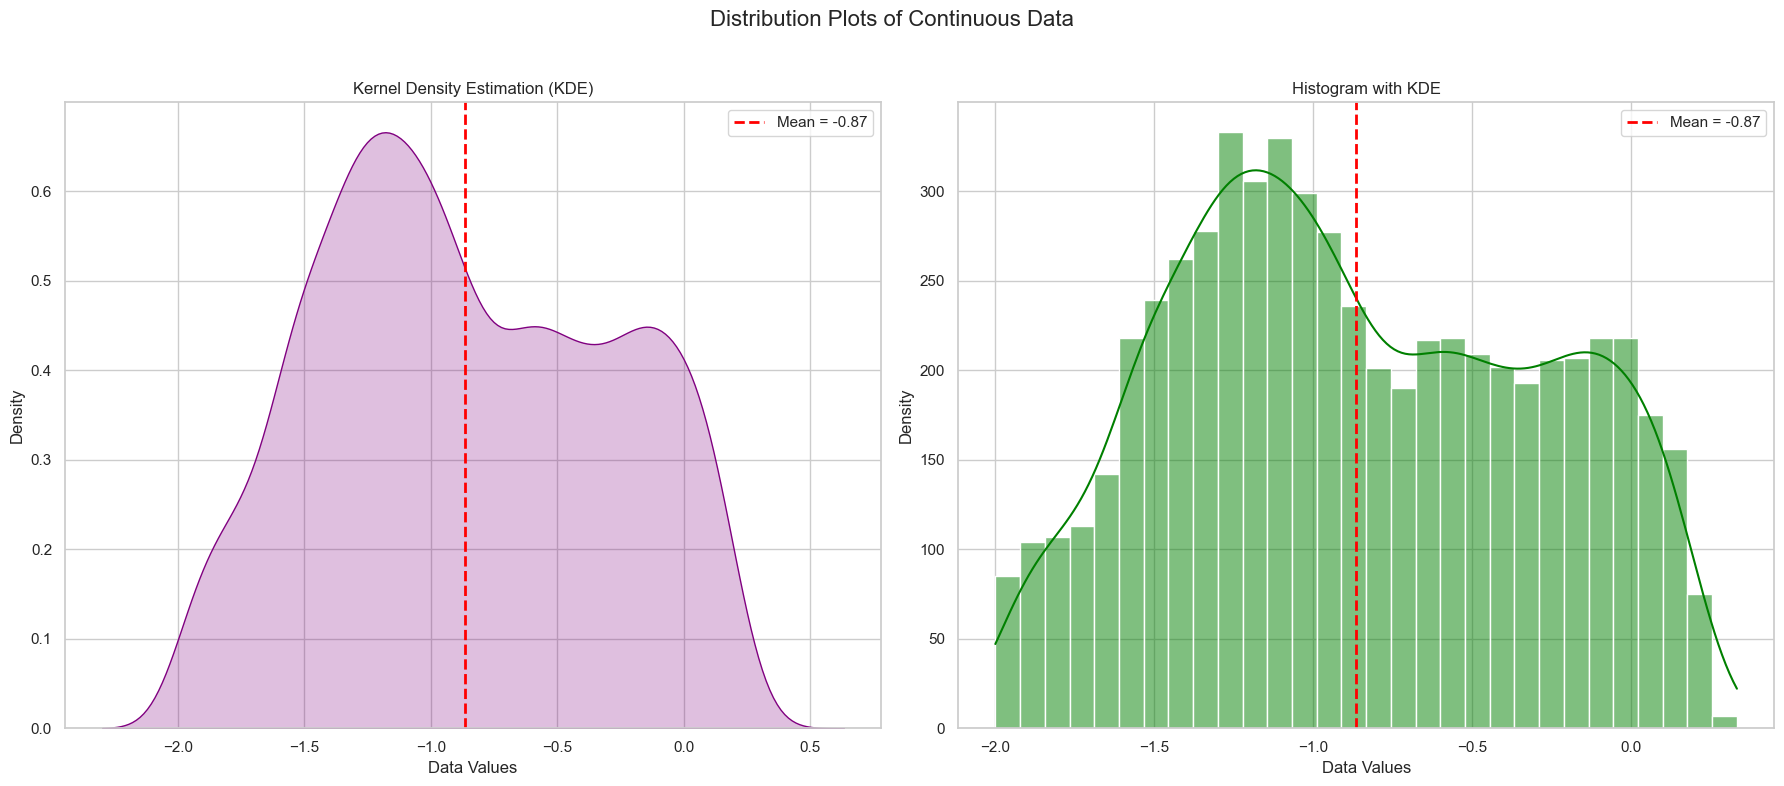

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generate some sample continuous data
np.random.seed(42)
data = np.random.normal(loc=0, scale=1, size=500)  # Normally distributed data

def plot_distribution(data):
    mean = sum(data)/len(data)
    # Set the style for better aesthetics
    sns.set(style="whitegrid")

    # Create a figure and axes for the subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # KDE Plot
    sns.kdeplot(data, shade=True, color='purple', ax=axes[0])
    axes[0].set_title('Kernel Density Estimation (KDE)')
    axes[0].set_xlabel('Data Values')
    axes[0].set_ylabel('Density')

    axes[0].axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean:.2f}')
    axes[0].legend()

    # Histogram with KDE overlay
    sns.histplot(data, bins=30, kde=True, color='green', ax=axes[1])
    axes[1].set_title('Histogram with KDE')
    axes[1].set_xlabel('Data Values')
    axes[1].set_ylabel('Density')

    axes[1].axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean:.2f}')
    axes[1].legend()

    # Display the plots
    plt.suptitle('Distribution Plots of Continuous Data', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()

import math
# Call the function to create and display the plots
data = [([*i.values()][0][1]['Z-Score']) for i in result]
mean = sum(data)/len(data)
plot_distribution(data)


In [128]:
# plot_distribution(df[0])
# mean = sum(df[0])/len(df[0])
df[0]

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
6016   -0.290949
6017   -0.361488
6018   -0.414093
6019   -0.462282
6020   -0.510238
Name: 0, Length: 6021, dtype: float64

In [130]:
import pandas as pd
data = [([*i.values()][0][1]['Z-Score']) for i in result]
df = pd.DataFrame(data)
df.skew()

0    0.114358
dtype: float64

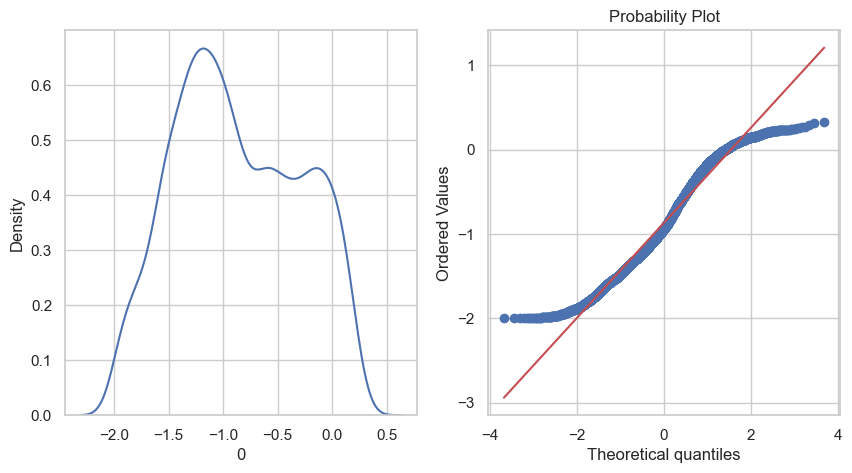

In [112]:
import scipy.stats as stats
import pylab

def normality(data,feature):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(data[feature])
    plt.subplot(1,2,2)
    stats.probplot(data[feature],plot=pylab)
    plt.show()

normality(df,0)

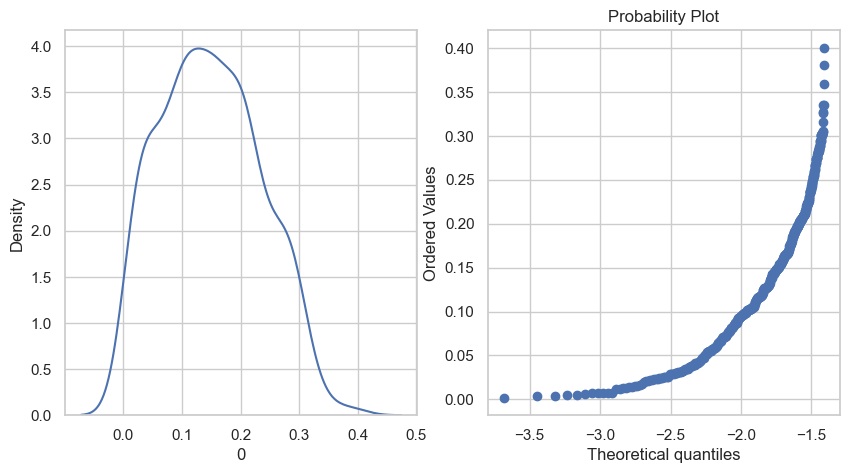

In [133]:
data = [([*i.values()][0][1]['Z-Score']) for i in result]
df = pd.DataFrame(data)
# df[0]=np.log(df[0])
# df[0]=(1/(df[0]))
# df[0]=stats.boxcox(df[0])
df[0]=(df[0]**(1/1.2))
# df[0]=(df[0]**(0.5))
#plotting to check the transformation
normality(df,0)

In [134]:
df.skew()

0    0.228583
dtype: float64

In [135]:
df

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
6016,0.299371
6017,0.334758
6018,0.359287
6019,0.380440
